# Statistical Analysis

Diabetes is a serious chronic disease in which individuals lose the ability to effectively regulate blood glucose levels, which can lead to a reduction in quality of life and life expectancy.

The Behavioral Risk Factor Surveillance System (BRFSS) is a health-related telephone survey collected annually by the CDC (Centers for Disease Control and Prevention in the United States). Each year, the survey gathers responses from thousands of Americans about health-related risk behaviors, chronic health conditions, and the use of preventive services. For this project, a dataset available on Kaggle for the year 2015 was used. 

https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

Dicionário de variáveis:

- `Diabetes_binary`: 0 = no diabetes, 1 = with diabetes
- `HighBP`: 0 = no high blood pressure, 1 = with high blood pressure
- `HighChol`: 0 = no high cholesterol, 1 = with high cholesterol
- `CholCheck`: 0 = never had a cholesterol test, 1 = had a cholesterol test at some point
- `BMI`: Body Mass Index (BMI)
- `Smoker`: 0 = non-smoker, 1 = smoker
- `Stroke`: 0 = sem histórico de AVC, 1 = com histórico de AVC
- `HeartDiseaseorAttack`: 0 = no history of heart disease or heart attack, 1 = with history of heart disease or heart attack
- `PhysActivity`: 0 = does not engage in physical activity, 1 = engages in physical activity
- `Fruits`: 0 = does not consume fruits, 1 = consumes fruits
- `Veggies`: 0 = does not consume vegetables, 1 = consumes vegetables
- `HvyAlcoholConsump`: 0 = does not consume alcohol in high amounts, 1 = consumes alcohol in high amounts
- `AnyHealthcare`: 0 = does not have health insurance, 1 = has health insurance
- `NoDocbcCost`: 0 = did not visit a doctor due to financial reasons, 1 = visited a doctor due to financial reasons (last 12 months)
- `GenHlth`: General health (1 to 5) - 1 = Excellent, 2 = Very good, 3 = Good, 4 = Fair, 5 = Poor
- `MentHlth`: In the last 30 days, how many days was mental health not good (0 to 30)
- `PhysHlth`: In the last 30 days, how many days was physical health not good (0 to 30)
- `DiffWalk`: 0 = no difficulty walking, 1 = has difficulty walking
- `Sex`: 0 = female, 1 = male
- `Age`: Age in ranges 1 = 18-24; 2 = 25-29; 3 = 30-34; 4 = 35-39; 5 = 40-44; 6 = 45-49; 7 = 50-54; 8 = 55-59; 9 = 60-64; 10 = 65-69; 11 = 70-74; 12 = 75-79; 13 = 80+
- `Education`: Education levels 1 = never attended school; 2 = elementary school; 3 = incomplete high school; 4 = high school; 5 = incomplete college or technical course; 6 = completed college or higher degrees
- `Income`: Annual income in ranges 1 = < 10,000; 2 = 10,000-14,999; 3 = 15,000-19,999; 4 = 20,000-24,999; 5 = 25,000-34,999; 6 = 35,000-49,999; 7 = 50,000-74,999; 8 = 75,000+

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, kstest, norm
import seaborn as sns

# funções desenvolvidas para o projeto
from src.helpers import (
    levene_analysis,
    manwhiteney_analysis,
    ttest_ind_analysis,
    remove_outliers,
)
from src.config import PROCESSED_DATA

In [2]:
df_diabetes_processed = pd.read_parquet(PROCESSED_DATA)

df_diabetes_processed.head()

,Diabetes,HighBloodPressure,HighCholesterol,CholesterolTest,BodyMassIndex,Smoker,Stroke,HeartProblem,PhysicalActivity,EatsFruits,...,HealthInsurance,NoDoctorMoney,GeneralHealth,MentalHealthDays,PhysicalHealthDays,WalkingDifficulty,Gender,AgeRange,EducationLevel,IncomeRange
0,No,Yes,No,Yes,26,No,No,No,Yes,No,...,Yes,No,Good,5,30,No,Male,35-39,College or higher,$75.000+
1,No,Yes,Yes,Yes,26,Yes,Yes,No,No,Yes,...,Yes,No,Good,0,0,No,Male,75-79,College or higher,$75.000+
2,No,No,No,Yes,26,No,No,No,Yes,Yes,...,Yes,No,Excellent,0,10,No,Male,80+,College or higher,$75.000+
3,No,Yes,Yes,Yes,28,Yes,No,No,Yes,Yes,...,Yes,No,Good,0,3,No,Male,70-74,College or higher,$75.000+
4,No,No,No,Yes,29,Yes,No,No,Yes,Yes,...,Yes,No,Very good,0,0,No,Female,55-59,College incomplete or Technical,$75.000+


In [3]:
df_diabetes_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Diabetes            70692 non-null  category
 1   HighBloodPressure   70692 non-null  category
 2   HighCholesterol     70692 non-null  category
 3   CholesterolTest     70692 non-null  category
 4   BodyMassIndex       70692 non-null  int8    
 5   Smoker              70692 non-null  category
 6   Stroke              70692 non-null  category
 7   HeartProblem        70692 non-null  category
 8   PhysicalActivity    70692 non-null  category
 9   EatsFruits          70692 non-null  category
 10  EatsVegetables      70692 non-null  category
 11  HeavyDrinking       70692 non-null  category
 12  HealthInsurance     70692 non-null  category
 13  NoDoctorMoney       70692 non-null  category
 14  GeneralHealth       70692 non-null  category
 15  MentalHealthDays    70692 non-null  

In [4]:
numeric_columns = df_diabetes_processed.select_dtypes(include="number").columns.tolist()

target = "Diabetes"

categorical_columns = df_diabetes_processed.select_dtypes(include="category").columns.tolist()
categorical_columns.remove(target)

binary_columns = df_diabetes_processed.nunique()[df_diabetes_processed.nunique() == 2].index.tolist()
binary_columns.remove(target)

non_binary_columns = list(set(categorical_columns) - set(binary_columns))

In [5]:
numeric_columns

['BodyMassIndex', 'MentalHealthDays', 'PhysicalHealthDays']

In [6]:
target

'Diabetes'

In [7]:
categorical_columns

['HighBloodPressure',
 'HighCholesterol',
 'CholesterolTest',
 'Smoker',
 'Stroke',
 'HeartProblem',
 'PhysicalActivity',
 'EatsFruits',
 'EatsVegetables',
 'HeavyDrinking',
 'HealthInsurance',
 'NoDoctorMoney',
 'GeneralHealth',
 'WalkingDifficulty',
 'Gender',
 'AgeRange',
 'EducationLevel',
 'IncomeRange']

In [8]:
binary_columns

['HighBloodPressure',
 'HighCholesterol',
 'CholesterolTest',
 'Smoker',
 'Stroke',
 'HeartProblem',
 'PhysicalActivity',
 'EatsFruits',
 'EatsVegetables',
 'HeavyDrinking',
 'HealthInsurance',
 'NoDoctorMoney',
 'WalkingDifficulty',
 'Gender']

In [9]:
non_binary_columns

['AgeRange', 'IncomeRange', 'GeneralHealth', 'EducationLevel']

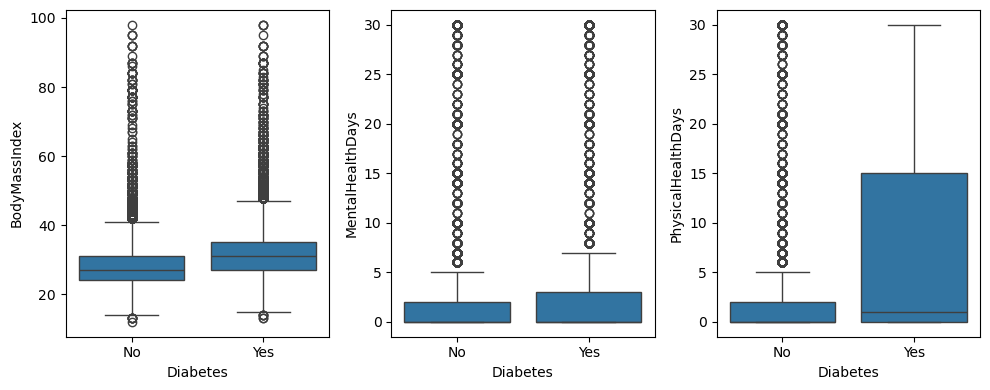

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for ax, column in zip(axs, numeric_columns):
    sns.boxplot(data=df_diabetes_processed, x=target, y=column, ax=ax)

plt.tight_layout()
plt.show()

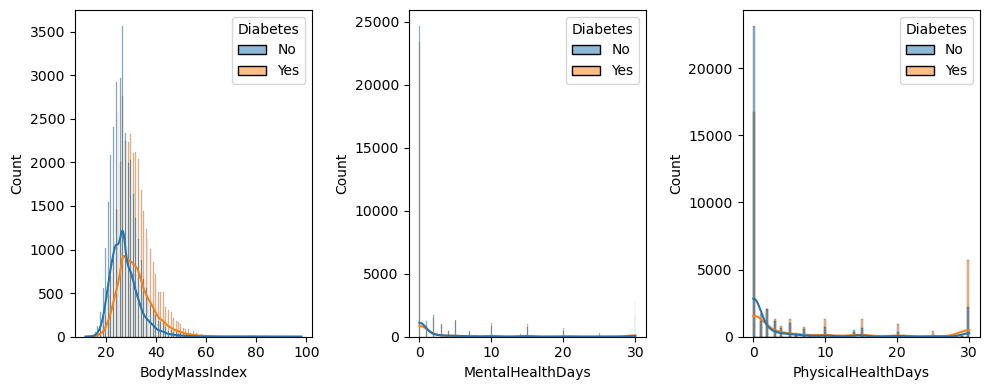

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for ax, column in zip(axs, numeric_columns):
    sns.histplot(data=df_diabetes_processed, x=column, hue=target, kde=True, ax=ax)

plt.tight_layout()
plt.show()

In [12]:
df_diabetes_processed.groupby(target, observed=False).describe().T

Diabetes                            No           Yes
BodyMassIndex      count  35346.000000  35346.000000
                   mean      27.769960     31.944011
                   std        6.187636      7.363401
                   min       12.000000     13.000000
                   25%       24.000000     27.000000
                   50%       27.000000     31.000000
                   75%       31.000000     35.000000
                   max       98.000000     98.000000
MentalHealthDays   count  35346.000000  35346.000000
                   mean       3.042268      4.461806
                   std        7.208408      8.947717
                   min        0.000000      0.000000
                   25%        0.000000      0.000000
                   50%        0.000000      0.000000
                   75%        2.000000      3.000000
                   max       30.000000     30.000000
PhysicalHealthDays count  35346.000000  35346.000000
                   mean       3.666355      7.954479
                   std        8.098339     11.301491
                   min        0.000000      0.000000
                   25%        0.000000      0.000000
                   50%        0.000000      1.000000
                   75%        2.000000     15.000000
                   max       30.000000     30.000000

In [13]:
df_diabetes_processed.corr(numeric_only=True)

,BodyMassIndex,MentalHealthDays,PhysicalHealthDays
BodyMassIndex,1.000000,0.104682,0.161862
MentalHealthDays,0.104682,1.000000,0.380272
PhysicalHealthDays,0.161862,0.380272,1.000000


In [14]:
df_diabetes_processed.groupby(target, observed=False).skew(numeric_only=True)

,BodyMassIndex,MentalHealthDays,PhysicalHealthDays
Diabetes,,,
No,2.231015,2.808070,2.480202
Yes,1.527018,2.065169,1.150047


In [15]:
df_diabetes_processed.groupby(target, observed=False)[numeric_columns].apply(pd.DataFrame.kurtosis)

,BodyMassIndex,MentalHealthDays,PhysicalHealthDays
Diabetes,,,
No,12.901012,7.012218,4.910598
Yes,5.717382,2.873176,-0.341922


In [16]:
bmi_yes = df_diabetes_processed.query("Diabetes == 'Yes'")["BodyMassIndex"].values

bmi_no = df_diabetes_processed.query("Diabetes == 'No'")["BodyMassIndex"].values

In [17]:
print(kstest(bmi_no, norm.cdf, args=(bmi_no.mean(), bmi_no.std())))
print(kstest(bmi_yes, norm.cdf, args=(bmi_yes.mean(), bmi_yes.std())))

KstestResult(statistic=0.1209153634702329, pvalue=0.0, statistic_location=28, statistic_sign=1)
KstestResult(statistic=0.10452803408478695, pvalue=0.0, statistic_location=33, statistic_sign=1)


In [18]:
dataframe_bmi = pd.DataFrame({"Sim": bmi_yes, "Não": bmi_no})

dataframe_bmi

,Sim,Não
0,30,26
1,25,26
2,28,26
3,23,28
4,27,29
...,...,...
35341,37,23
35342,29,29
35343,25,24
35344,18,53


In [19]:
levene_analysis(dataframe_bmi, center="median")

Levene's Test
levene_statistics=888.297
At least one variance is different (p-value: 0.000)


In [20]:
ttest_ind_analysis(dataframe_bmi, equal_variances=False)

Student's t-Test
ttest_statistics=81.591
Rejects the null hypothesis (p-value: 0.000)


In [21]:
manwhiteney_analysis(dataframe_bmi)

Mann-Whitney Test
mw_statistics=861173484.000
Rejects the null hypothesis (p-value: 0.000)


In [22]:
df_diabetes_no_outliers = df_diabetes_processed.copy()

for column in numeric_columns:
    df_diabetes_no_outliers[column] = remove_outliers(df_diabetes_no_outliers[column])

df_diabetes_no_outliers.describe()

,BodyMassIndex,MentalHealthDays,PhysicalHealthDays
count,68511.000000,58876.000000,60068.000000
mean,29.129673,0.526615,1.880619
std,5.695466,1.271375,3.727202
min,13.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000
50%,28.000000,0.000000,0.000000
75%,33.000000,0.000000,2.000000
max,45.000000,5.000000,15.000000


In [23]:
df_diabetes_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Diabetes            70692 non-null  category
 1   HighBloodPressure   70692 non-null  category
 2   HighCholesterol     70692 non-null  category
 3   CholesterolTest     70692 non-null  category
 4   BodyMassIndex       68511 non-null  float64 
 5   Smoker              70692 non-null  category
 6   Stroke              70692 non-null  category
 7   HeartProblem        70692 non-null  category
 8   PhysicalActivity    70692 non-null  category
 9   EatsFruits          70692 non-null  category
 10  EatsVegetables      70692 non-null  category
 11  HeavyDrinking       70692 non-null  category
 12  HealthInsurance     70692 non-null  category
 13  NoDoctorMoney       70692 non-null  category
 14  GeneralHealth       70692 non-null  category
 15  MentalHealthDays    58876 non-null  

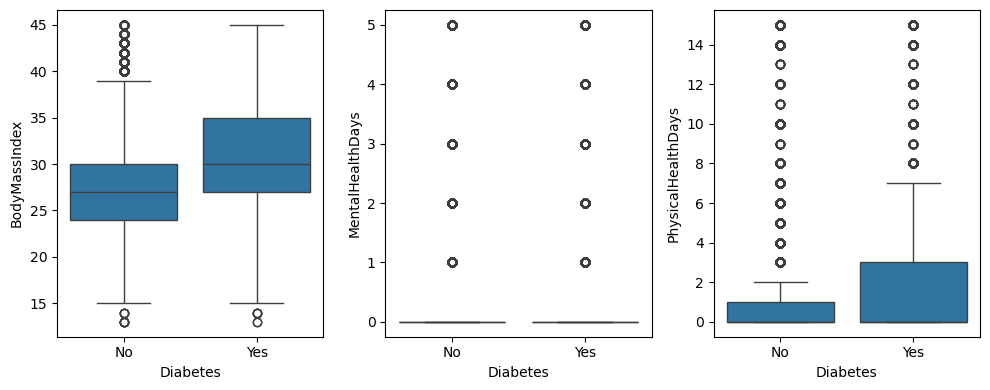

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for ax, column in zip(axs, numeric_columns):
    sns.boxplot(data=df_diabetes_no_outliers, x=target, y=column, ax=ax)

plt.tight_layout()
plt.show()

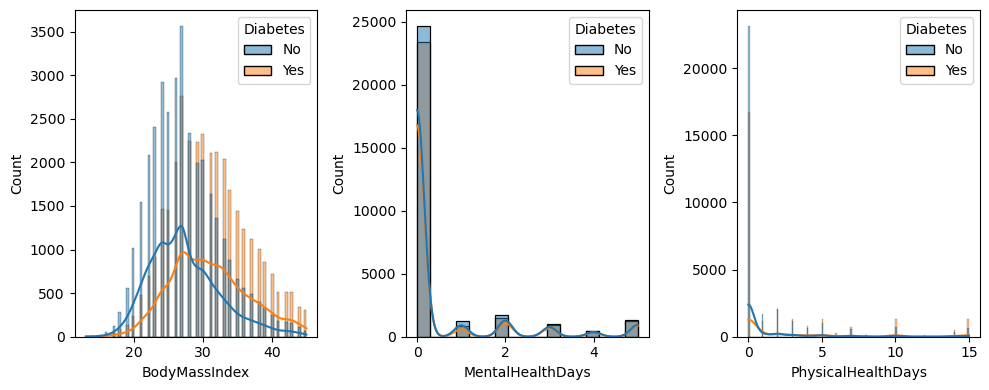

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for ax, column in zip(axs, numeric_columns):
    sns.histplot(data=df_diabetes_no_outliers, x=column, hue=target, kde=True, ax=ax)

plt.tight_layout()
plt.show()

In [26]:
df_diabetes_no_outliers.groupby(target, observed=False).skew(numeric_only=True)

,BodyMassIndex,MentalHealthDays,PhysicalHealthDays
Diabetes,,,
No,0.714415,2.454599,2.874805
Yes,0.323244,2.507093,1.856026


In [27]:
df_diabetes_no_outliers.groupby(target, observed=False)[numeric_columns].apply(pd.DataFrame.kurtosis)

,BodyMassIndex,MentalHealthDays,PhysicalHealthDays
Diabetes,,,
No,0.481335,5.003764,8.079214
Yes,-0.343434,5.185706,2.367289


In [28]:
bmi_yes_no_outliers = df_diabetes_no_outliers.query("Diabetes == 'Yes'")["BodyMassIndex"].values
bmi_no_no_outliers = df_diabetes_no_outliers.query("Diabetes == 'No'")["BodyMassIndex"].values

dataframe_bmi_no_outliers = pd.DataFrame({"Yes": bmi_yes_no_outliers, "No": bmi_no_no_outliers})
dataframe_bmi_no_outliers

,Yes,No
0,30.0,26.0
1,25.0,26.0
2,28.0,26.0
3,23.0,28.0
4,27.0,29.0
...,...,...
35341,37.0,23.0
35342,29.0,29.0
35343,25.0,24.0
35344,18.0,NaN


In [29]:
bmi_no_no_outliers.mean()

nan

In [30]:
dataframe_bmi_no_outliers["No"].mean()

27.39410195358444

In [31]:
print(
    kstest(
        dataframe_bmi_no_outliers["No"], 
        norm.cdf, 
        args=(dataframe_bmi_no_outliers["No"].mean(), 
              dataframe_bmi_no_outliers["No"].std()), 
        nan_policy="omit")
)

print(
    kstest(
        dataframe_bmi_no_outliers["Yes"], 
        norm.cdf, 
        args=(dataframe_bmi_no_outliers["Yes"].mean(), 
              dataframe_bmi_no_outliers["Yes"].std()), 
        nan_policy="omit")
)

KstestResult(statistic=0.10815079726309146, pvalue=0.0, statistic_location=27.0, statistic_sign=1)
KstestResult(statistic=0.07345716240963396, pvalue=2.3370072025339465e-158, statistic_location=30.0, statistic_sign=1)


In [32]:
levene_analysis(dataframe_bmi_no_outliers, center="median")

Levene's Test
levene_statistics=532.986
At least one variance is different (p-value: 0.000)


In [33]:
ttest_ind_analysis(dataframe_bmi_no_outliers, equal_variances=False)

Student's t-Test
ttest_statistics=85.248
Rejects the null hypothesis (p-value: 0.000)


In [34]:
manwhiteney_analysis(dataframe_bmi_no_outliers)

Mann-Whitney Test
mw_statistics=801702843.000
Rejects the null hypothesis (p-value: 0.000)


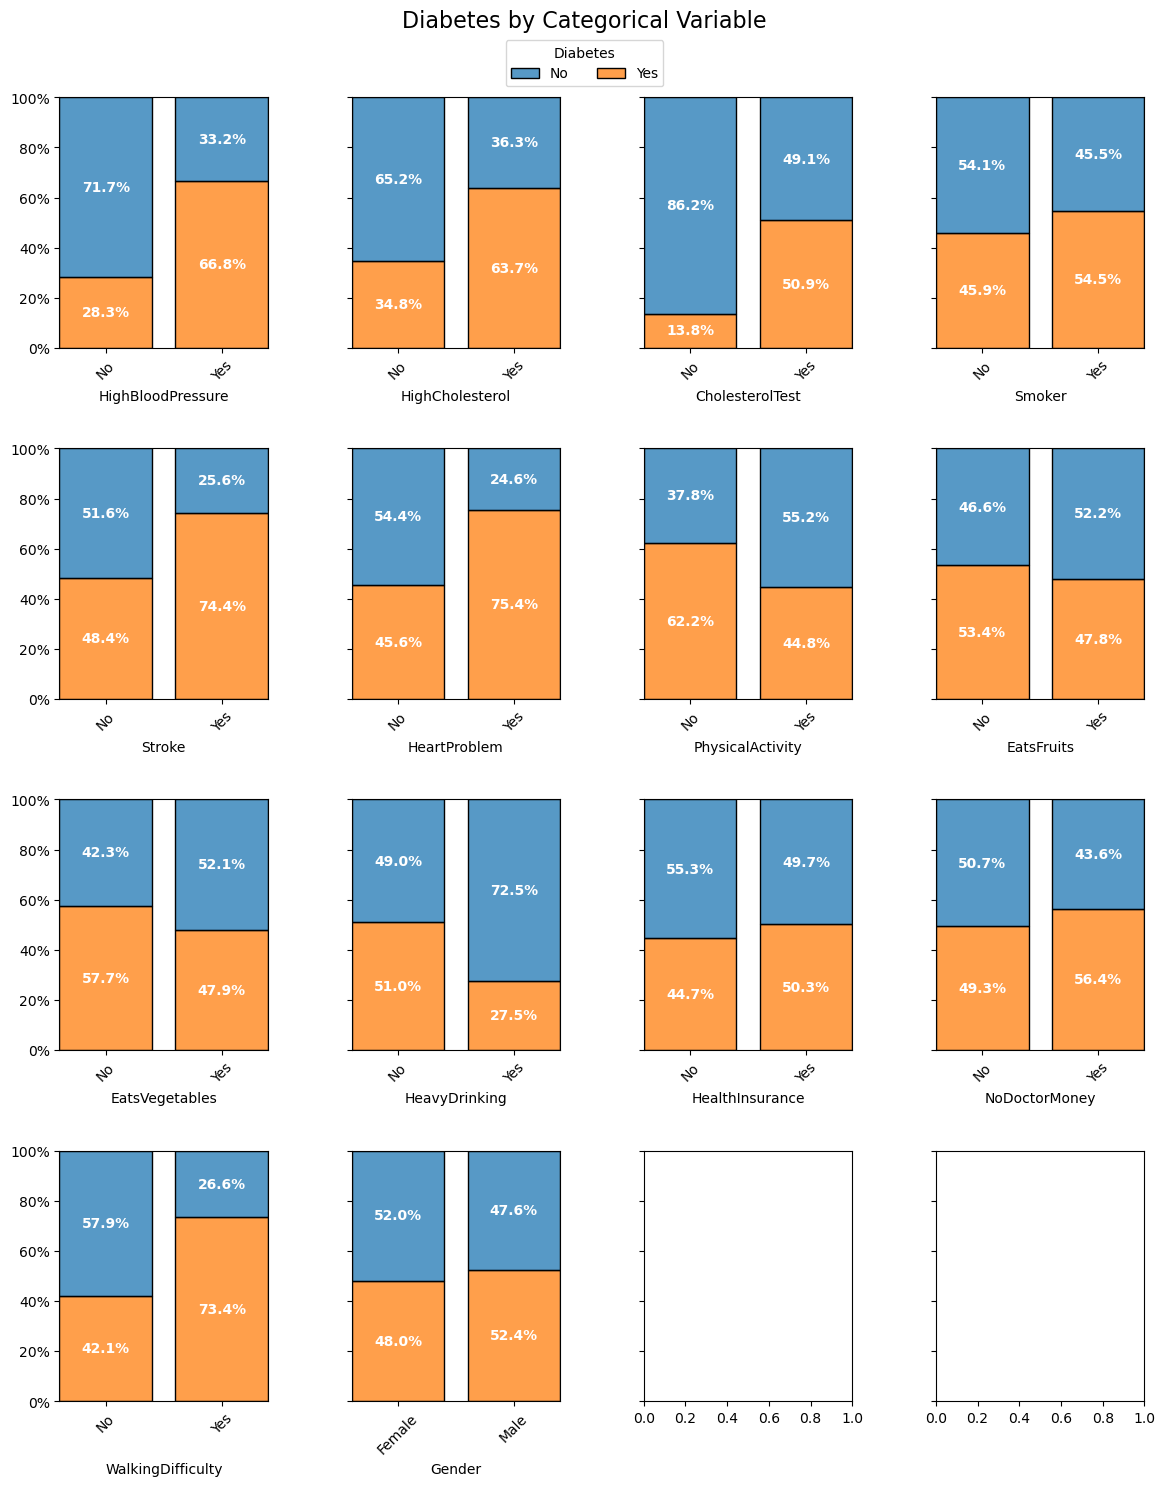

In [35]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(14, 16), sharey=True)

for i, column in enumerate(binary_columns):
    h = sns.histplot(x=column,
                     hue=target,
                     data=df_diabetes_processed,
                     multiple="fill",
                     ax=axs.flat[i],
                     stat="percent",
                     shrink=0.8)
    h.tick_params(axis="x", labelrotation=45)

    h.yaxis.set_major_formatter(PercentFormatter(1))
    h.set_ylabel("")

    for bar in h.containers:
        h.bar_label(bar, label_type="center", labels=[f"{b.get_height():.1%}" for b in bar], 
                    color="white", weight="bold")

    legend = h.get_legend()
    legend.remove()

labels = [text.get_text() for text in legend.get_texts()]

fig.legend(handles=legend.legend_handles, labels=labels, loc="upper center", ncols=2, title="Diabetes", 
           bbox_to_anchor=(0.5, 0.965))
fig.suptitle("Diabetes by Categorical Variable", fontsize=16)

fig.align_labels()

plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.925)

plt.show()

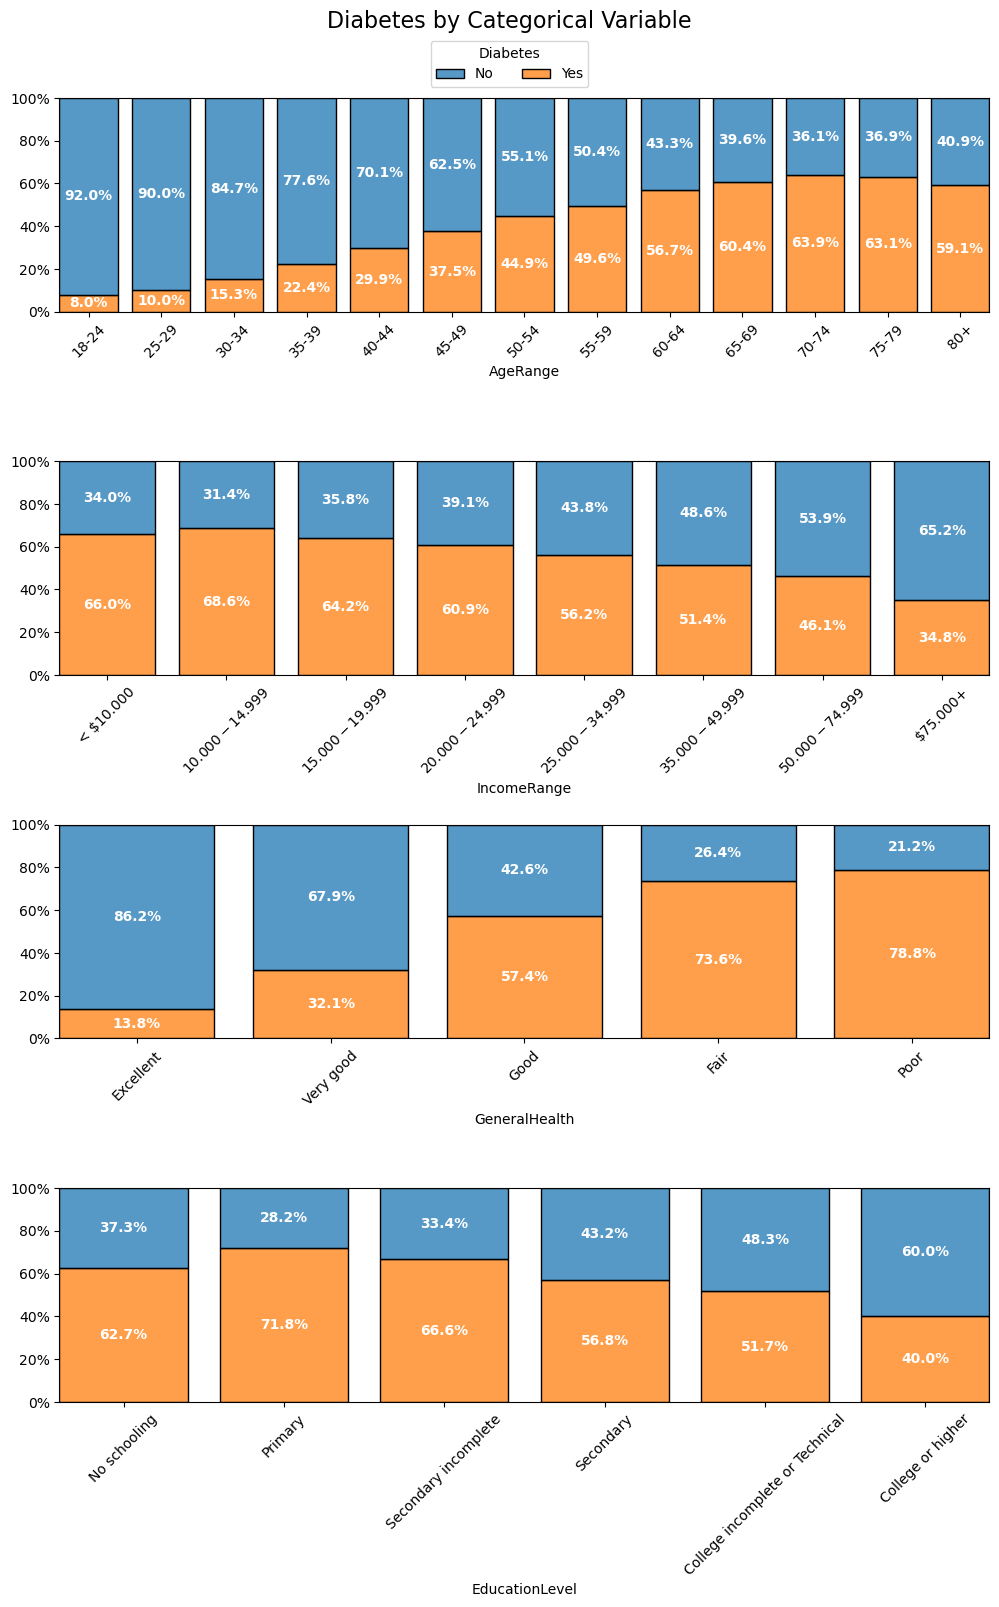

In [36]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12, 16))

for i, column in enumerate(non_binary_columns):
    h = sns.histplot(x=column,
                     hue=target,
                     data=df_diabetes_processed,
                     multiple="fill",
                     ax=axs.flat[i],
                     stat="percent",
                     shrink=0.8)
    h.tick_params(axis="x", labelrotation=45)

    h.yaxis.set_major_formatter(PercentFormatter(1))
    h.set_ylabel("")

    for bar in h.containers:
        h.bar_label(bar, label_type="center", labels=[f"{b.get_height():.1%}" for b in bar], 
                    color="white", weight="bold")

    legend = h.get_legend()
    legend.remove()

labels = [text.get_text() for text in legend.get_texts()]

fig.legend(handles=legend.legend_handles, labels=labels, loc="upper center", ncols=2, title="Diabetes", 
           bbox_to_anchor=(0.5, 0.965))
fig.suptitle("Diabetes by Categorical Variable", fontsize=16)

fig.align_labels()

plt.subplots_adjust(wspace=0.1, hspace=0.7, top=0.925)

plt.show()

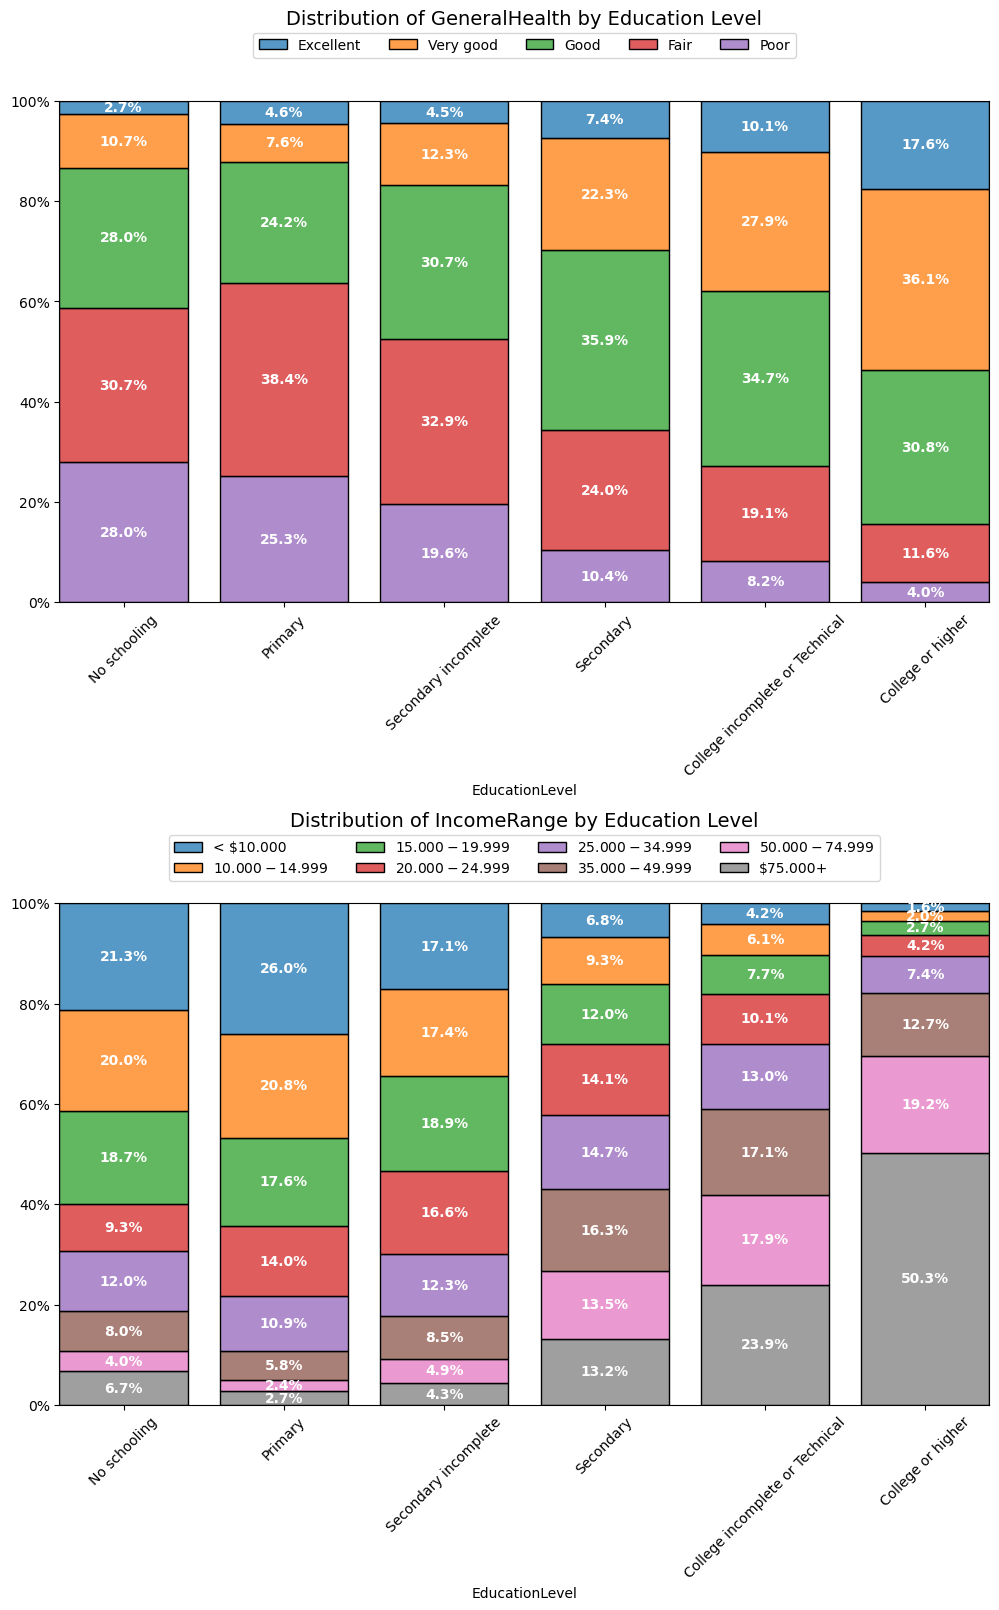

In [37]:
analysis_columns = ["GeneralHealth", "IncomeRange"]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 16))

for ax, column in zip(axs.flatten(), analysis_columns):
    h = sns.histplot(x="EducationLevel",
                     hue=column,
                     data=df_diabetes_processed,
                     multiple="fill",
                     ax=ax,
                     stat="percent",
                     shrink=0.8)
    h.tick_params(axis="x", labelrotation=45)

    h.yaxis.set_major_formatter(PercentFormatter(1))
    h.set_ylabel("")

    for bar in h.containers:
        h.bar_label(bar, label_type="center", labels=[f"{b.get_height():.1%}" for b in bar], 
                    color="white", weight="bold")

    legend = h.get_legend()

    labels = [text.get_text() for text in legend.get_texts()]

    numero_itens = len(df_diabetes_processed[column].cat.categories)

    ax.legend(
        handles=legend.legend_handles,
        labels=labels,
        loc="upper center",
        ncols=numero_itens if numero_itens <= 6 else min(4, numero_itens),
        bbox_to_anchor=(0.5, 1.15),
    )

    ax.set_title(f"Distribution of {column} by Education Level", fontsize=14, pad=55)

plt.subplots_adjust(wspace=0.1, hspace=0.6, top=0.925)

plt.show()

In [38]:
contingency_tables = {}

for column in df_diabetes_processed.select_dtypes("category").columns:
    if column != target:
        contingency_tables[column] = pd.crosstab(df_diabetes_processed[target], df_diabetes_processed[column])

In [39]:
contingency_tables["HighBloodPressure"]

HighBloodPressure,No,Yes
Diabetes,,
No,22118,13228
Yes,8742,26604


In [40]:
for column in df_diabetes_processed.select_dtypes("category").columns:
    if column != target:
        display(
            pd.crosstab(
                df_diabetes_processed[target],
                df_diabetes_processed[column],
                margins=True,
                normalize="index"
            ).style.format("{:.2%}"))

HighBloodPressure,No,Yes
Diabetes,,
No,62.58%,37.42%
Yes,24.73%,75.27%
All,43.65%,56.35%


HighCholesterol,No,Yes
Diabetes,,
No,61.87%,38.13%
Yes,32.99%,67.01%
All,47.43%,52.57%


CholesterolTest,No,Yes
Diabetes,,
No,4.27%,95.73%
Yes,0.68%,99.32%
All,2.47%,97.53%


Smoker,No,Yes
Diabetes,,
No,56.77%,43.23%
Yes,48.18%,51.82%
All,52.47%,47.53%


Stroke,No,Yes
Diabetes,,
No,96.81%,3.19%
Yes,90.75%,9.25%
All,93.78%,6.22%


HeartProblem,No,Yes
Diabetes,,
No,92.73%,7.27%
Yes,77.71%,22.29%
All,85.22%,14.78%


PhysicalActivity,No,Yes
Diabetes,,
No,22.45%,77.55%
Yes,36.95%,63.05%
All,29.70%,70.30%


EatsFruits,No,Yes
Diabetes,,
No,36.19%,63.81%
Yes,41.46%,58.54%
All,38.82%,61.18%


EatsVegetables,No,Yes
Diabetes,,
No,17.89%,82.11%
Yes,24.36%,75.64%
All,21.12%,78.88%


HeavyDrinking,No,Yes
Diabetes,,
No,93.81%,6.19%
Yes,97.65%,2.35%
All,95.73%,4.27%


HealthInsurance,No,Yes
Diabetes,,
No,4.99%,95.01%
Yes,4.02%,95.98%
All,4.50%,95.50%


NoDoctorMoney,No,Yes
Diabetes,,
No,91.80%,8.20%
Yes,89.41%,10.59%
All,90.61%,9.39%


GeneralHealth,Excellent,Very good,Good,Fair,Poor
Diabetes,,,,,
No,20.21%,38.17%,28.21%,9.94%,3.48%
Yes,3.23%,18.05%,38.07%,27.70%,12.95%
All,11.72%,28.11%,33.14%,18.82%,8.22%


WalkingDifficulty,No,Yes
Diabetes,,
No,86.58%,13.42%
Yes,62.88%,37.12%
All,74.73%,25.27%


Gender,Female,Male
Diabetes,,
No,56.51%,43.49%
Yes,52.09%,47.91%
All,54.30%,45.70%


AgeRange,18-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80+
Diabetes,,,,,,,,,,,,,
No,2.55%,3.55%,4.91%,6.13%,6.99%,8.22%,10.71%,12.28%,12.39%,12.16%,8.21%,5.63%,6.27%
Yes,0.22%,0.40%,0.89%,1.77%,2.97%,4.93%,8.74%,12.06%,16.22%,18.55%,14.54%,9.63%,9.08%
All,1.38%,1.97%,2.90%,3.95%,4.98%,6.58%,9.72%,12.17%,14.30%,15.36%,11.38%,7.63%,7.68%


EducationLevel,No schooling,Primary,Secondary incomplete,Secondary,College incomplete or Technical,College or higher
Diabetes,,,,,,
No,0.08%,1.31%,3.26%,23.78%,27.38%,44.19%
Yes,0.13%,3.35%,6.50%,31.31%,29.29%,29.42%
All,0.11%,2.33%,4.88%,27.55%,28.33%,36.81%


IncomeRange,< $10.000,$10.000-$14.999,$15.000-$19.999,$20.000-$24.999,$25.000-$34.999,$35.000-$49.999,$50.000-$74.999,$75.000+
Diabetes,,,,,,,,
No,3.47%,3.99%,5.63%,7.37%,9.92%,14.13%,17.43%,38.06%
Yes,6.74%,8.73%,10.09%,11.47%,12.74%,14.97%,14.90%,20.36%
All,5.11%,6.36%,7.86%,9.42%,11.33%,14.55%,16.16%,29.21%


In [41]:
for column, tabela in contingency_tables.items():
    chi2, p_value, _, _ = chi2_contingency(tabela)
    print(f"{column} - {chi2=} - {p_value=}")

HighBloodPressure - chi2=10287.972984997781 - p_value=0.0
HighCholesterol - chi2=5911.8066998822505 - p_value=0.0
CholesterolTest - chi2=939.6317718798653 - p_value=2.3798712773419562e-206
Smoker - chi2=522.4810772937883 - p_value=1.2211053080400827e-115
Stroke - chi2=1111.0793074560897 - p_value=1.290837098922016e-243
HeartProblem - chi2=3161.7202445322782 - p_value=0.0
PhysicalActivity - chi2=1778.9607035956992 - p_value=0.0
EatsFruits - chi2=206.50090830615105 - p_value=7.967064756507964e-47
EatsVegetables - chi2=444.0806516898606 - p_value=1.4007103685991128e-98
HeavyDrinking - chi2=635.0865339749427 - p_value=3.9133962745676324e-140
HealthInsurance - chi2=37.79561046998934 - p_value=7.855833890083924e-10
NoDoctorMoney - chi2=118.4167174482265 - p_value=1.4053255735064045e-27
GeneralHealth - chi2=12304.318979903528 - p_value=0.0
WalkingDifficulty - chi2=5253.694843161374 - p_value=0.0
Gender - chi2=139.26185542886512 - p_value=3.860395909809483e-32
AgeRange - chi2=6179.057132257292

In [42]:
correlation_results = df_diabetes_processed.select_dtypes("category").apply(lambda column: column.cat.codes).corr(
    method="spearman", numeric_only=False)

correlation_results

,Diabetes,HighBloodPressure,HighCholesterol,CholesterolTest,Smoker,Stroke,HeartProblem,PhysicalActivity,EatsFruits,EatsVegetables,HeavyDrinking,HealthInsurance,NoDoctorMoney,GeneralHealth,WalkingDifficulty,Gender,AgeRange,EducationLevel,IncomeRange
Diabetes,1.000000,0.381516,0.289213,0.115382,0.085999,0.125427,0.211523,-0.158666,-0.054077,-0.079293,-0.094853,0.023191,0.040977,0.414259,0.272646,0.044413,0.261620,-0.169926,-0.232529
HighBloodPressure,0.381516,1.000000,0.316515,0.103283,0.087438,0.129060,0.210750,-0.136102,-0.040852,-0.066624,-0.027030,0.035764,0.026517,0.324038,0.234784,0.040819,0.322180,-0.143543,-0.196896
HighCholesterol,0.289213,0.316515,1.000000,0.085981,0.093398,0.099786,0.181187,-0.090453,-0.047384,-0.042836,-0.025443,0.031532,0.033199,0.239138,0.162043,0.017324,0.217974,-0.083177,-0.110289
CholesterolTest,0.115382,0.103283,0.085981,1.000000,-0.004331,0.022529,0.043497,-0.008249,0.017384,0.000349,-0.027146,0.106800,-0.062669,0.060257,0.044430,-0.007991,0.099208,-0.007693,0.007271
Smoker,0.085999,0.087438,0.093398,-0.004331,1.000000,0.064658,0.124418,-0.079823,-0.074811,-0.029926,0.077835,-0.012939,0.035799,0.149960,0.119789,0.112125,0.098822,-0.152918,-0.112241
Stroke,0.125427,0.129060,0.099786,0.022529,0.064658,1.000000,0.223394,-0.079985,-0.008996,-0.047601,-0.023395,0.006484,0.036198,0.182517,0.192266,0.003822,0.123544,-0.071889,-0.134487
HeartProblem,0.211523,0.210750,0.181187,0.043497,0.124418,0.223394,1.000000,-0.098223,-0.019436,-0.036315,-0.037130,0.015687,0.036029,0.268815,0.232611,0.098161,0.225231,-0.093727,-0.148924
PhysicalActivity,-0.158666,-0.136102,-0.090453,-0.008249,-0.079823,-0.079985,-0.098223,1.000000,0.133813,0.149322,0.019111,0.027089,-0.063302,-0.270967,-0.276868,0.051753,-0.092685,0.193831,0.202370
EatsFruits,-0.054077,-0.040852,-0.047384,0.017384,-0.074811,-0.008996,-0.019436,0.133813,1.000000,0.238605,-0.033246,0.029385,-0.045843,-0.099559,-0.050784,-0.088723,0.067778,0.104653,0.076732
EatsVegetables,-0.079293,-0.066624,-0.042836,0.000349,-0.029926,-0.047601,-0.036315,0.149322,0.238605,1.000000,0.022090,0.029152,-0.037146,-0.117258,-0.084072,-0.052604,-0.017208,0.153539,0.155816


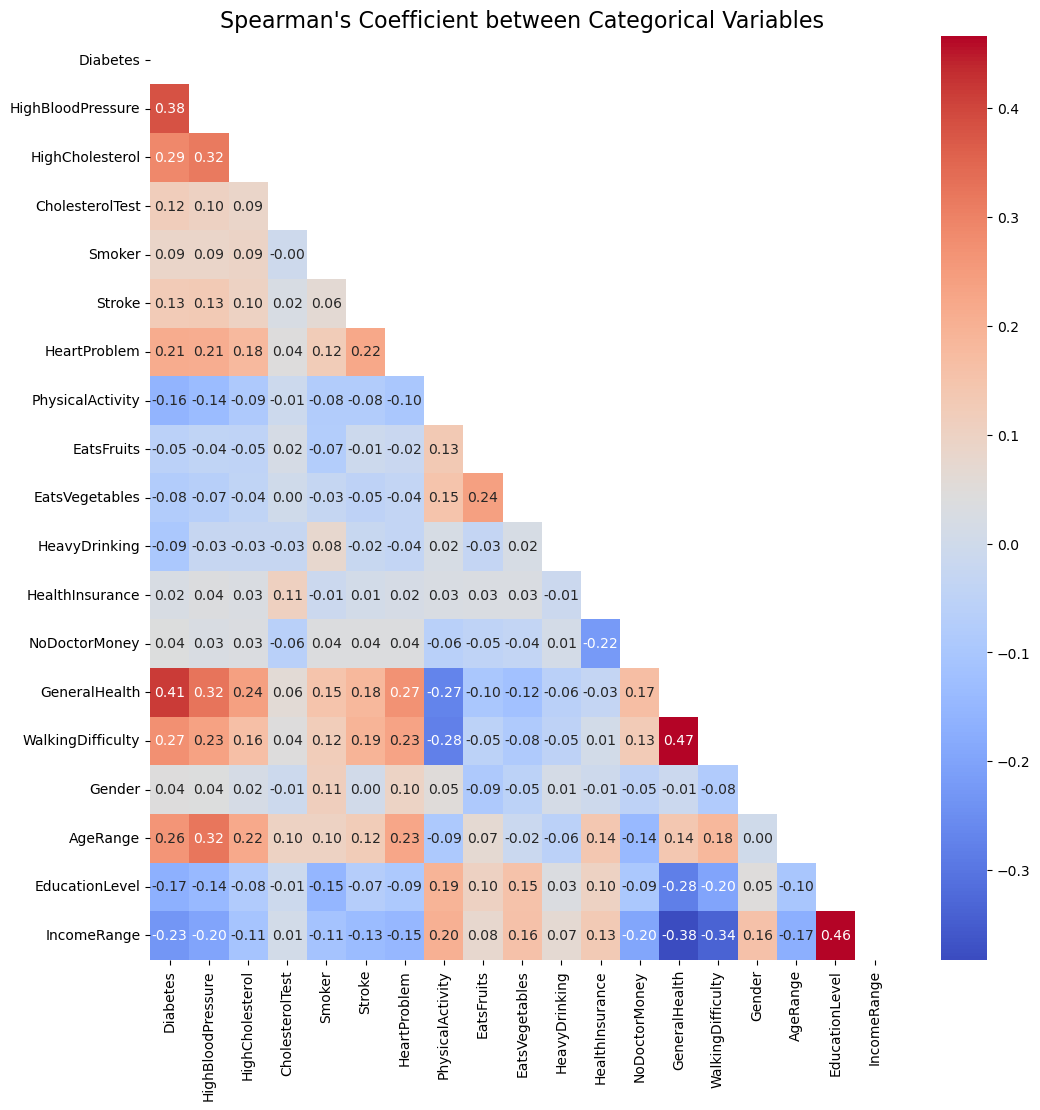

In [43]:
matrix = np.triu(correlation_results)

fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(correlation_results, mask=matrix, annot=True, fmt=".2f", ax=ax, cmap="coolwarm")

plt.title("Spearman's Coefficient between Categorical Variables", fontsize=16)

plt.show()